<a href="https://colab.research.google.com/github/vadim-privalov/Sorevnovania/blob/main/%D0%9A%D0%BE%D1%81%D0%BC%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D0%BE%D1%80%D0%B0%D0%B1%D0%BB%D1%8C_%D0%A2%D0%B8%D1%82%D0%B0%D0%BD%D0%B8%D0%BA_%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%8F_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> В этом соревновании ваша задача состоит в том, чтобы предсказать, был ли пассажир перенесен в другое измерение во время столкновения космического корабля "Титаник " с пространственно-временной аномалией. Чтобы помочь вам сделать эти прогнозы, вам дается набор личных записей, извлеченных из поврежденной компьютерной системы корабля.



Описание файлов и полей данных
train.csv — личные записи примерно двух третей (~8700) пассажиров, которые будут использоваться в качестве обучающих данных.
PassengerId- Уникальный идентификатор для каждого пассажира. Каждый идентификатор принимает форму , gggg_ppгде ggggуказывает группу, с которой путешествует пассажир, и ppявляется их номером в группе. Люди в группе часто являются членами семьи, но не всегда.
HomePlanet- Планета, с которой вылетел пассажир, как правило, планета его постоянного проживания.
CryoSleep- Указывает, решил ли пассажир быть переведен в режим анабиоза на время рейса. Пассажиры, находящиеся в криосонном состоянии, находятся в своих каютах.
Cabin- Номер каюты, в которой находится пассажир. Принимает вид deck/num/side, где sideможет быть либо Pза левый , либо Sза правый борт .
Destination- Планета, на которую будет высаживаться пассажир.
Age- Возраст пассажира.
VIP- Оплатил ли пассажир специальное VIP-обслуживание во время рейса.
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck- Сумма, которую пассажир выставил в счет за каждое из многочисленных роскошных удобств космического корабля Титаник .
Name- Имя и фамилия пассажира.
Transported- Был ли пассажир перенесён в другое измерение. Это цель, столбец, который вы пытаетесь предсказать.
test.csv — личные записи оставшейся трети (~ 4300) пассажиров, которые будут использоваться в качестве тестовых данных. Ваша задача состоит в том, чтобы предсказать значение Transportedдля пассажиров в этом наборе.
sample_submission.csv — файл отправки в правильном формате.
PassengerId- Id для каждого пассажира в тестовом наборе.
Transported- Цель. Для каждого пассажира предскажите либо Trueили False.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from google.colab import files

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf # импортируем tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer,tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Embedding, SpatialDropout1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
import zipfile # для работы с архивами zip

import os
#Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline
# устанавливаем свежий Kaggle API
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 5.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=c8986e47170f590e02f6b94d12fc0fcb451712912c77ebba08410fb12db252b2
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def Init_Kaggle():
    try:
        # Создаём правильную папку для ключа Каггл
        # в Колабе, она должна быть такой по требованию Каггл
        !mkdir ~/.kaggle
        # переходим в папку, теперь это путь по умолчанию
        %cd ~/.kaggle
        # запускаем - подключаем Google Drive - будем скачивать с него, так намного быстрее и удобнее
        # после запуска переходим по ссылке, которая появится, для идентификации
        # копируем оттуда код authorization code и вставляем здесь в окошко
        drive.mount('/content/drive')
        # нужно зарегистрироваться на Каггл и скачать ключ для взаимодействия с API
        # соревновательной системы Каггла kaggle.json. Нужно скопировать его в папку
        # Google Drive, предварительно её создав: /content/drive/My Drive/datasets/kaggle/
        !cp '/content/drive/MyDrive/datasets/kaggle/kaggle.json' '/root/.kaggle/kaggle.json'
        # выводим версию API Kaggle:
        !kaggle --version
        !ls
        print(' Ключи Kaggle успешно установлены! ')
    except:
        print(' При установке ключей Kaggle произошла ошибка! ')

In [4]:
def Load_data_from_Kaggle():
    # считаем заполненную базу данных из kaggle
    %cd ~/.kaggle
    print('скачиваем данные с Каггл:')
    !kaggle competitions download -c spaceship-titanic
    print('загружаем из архива, распаковываем:')
    z = zipfile.ZipFile('spaceship-titanic.zip', 'r')
    z.extractall()
    # удаляем архив, чтобы не занимал место на диске
    !rm spaceship-titanic.zip
    #Считываем данные с помощью pandas из двух файлов
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    sample_submission = pd.read_csv('sample_submission.csv')
    return train, test, sample_submission

In [5]:
Init_Kaggle() # устанавливаем кючи кагл

/root/.kaggle
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Kaggle API 1.5.12
kaggle.json
 Ключи Kaggle успешно установлены! 


In [6]:
train, test, sample_submission = Load_data_from_Kaggle() # считаем заполненную базу данных из kaggle
train.head()

/root/.kaggle
скачиваем данные с Каггл:
  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 78.1MB/s]
загружаем из архива, распаковываем:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [7]:
columns = train.columns.tolist() # выведем названия столбцов, что бы их потом переименовать
columns

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Name',
 'Transported']

In [8]:
train.info() # Проверяем значение каждой колонки должны иметь заданный тип данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


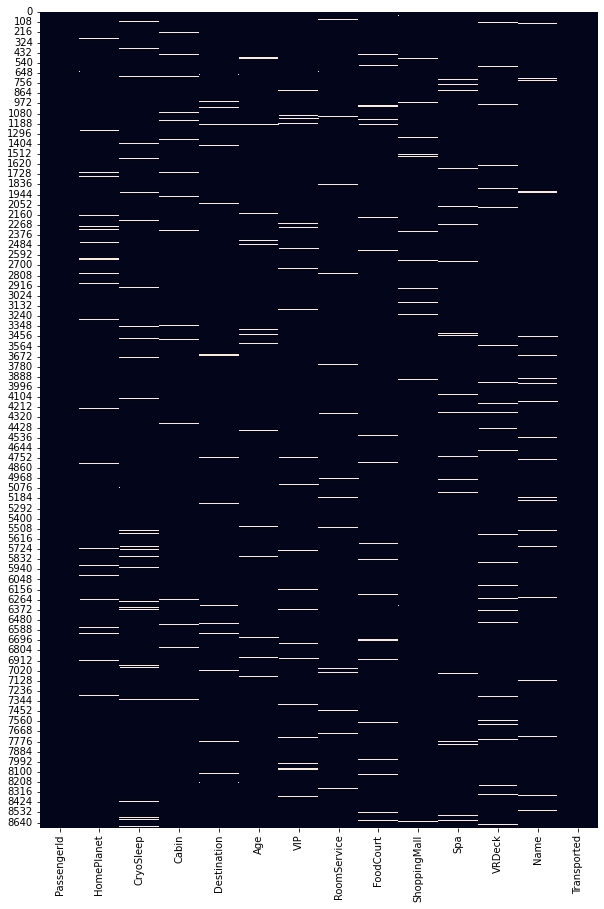

In [9]:
import seaborn as sns
from matplotlib.pyplot import figure
figure(figsize = (10, 15))
sns.heatmap(train.isnull(), cbar=False)

In [10]:
#  Возраст
colum_num = 5
# создадим вспомогательную функцию для определния значения объема по 3 параметрам 
def Value_string_det (a1,a2,a3,n_columns):
    try: # пробуем получить значение по трем ключевым значениям 'Класс здания', 'Район', 'Год'
        answ = train.iloc[(train[((train.iloc[:,1] == a1) & (train.iloc[:,2] == a2) & (train.iloc[:,3] == a3))]).index,\
                            n_columns ].value_counts().index[0]
    except:
        try: # в случае если операция не дала результа определяем значение поля на основе 'Класс здания' и максимально частоты использования. 
            answ = train.iloc[(train[df_house.iloc[:,1] == a1]).index,n_columns].value_counts().index[0]
        except: # в случае если с помощью предыдущих операций, мы не получили результат, то возвращаем значение, чаще встречающееся по все базе
            answ = train.iloc[:,n_columns].value_counts().index[0]
    
    return answ

In [11]:
maskValue = train.iloc[:,colum_num].isna() # создаем маску с пустыми значениями для колонки "Забор"
df_val = train.loc[maskValue,:] # создаем вспомогательным датафрейм
print(df_val.shape) # выведем размерность этого дата фрейма
df_val.head(10) # выведем на экран строки с пустыми значениями для колонки "Забор"

(179, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
50,0052_01,Earth,False,G/6/S,TRAPPIST-1e,NaN,False,4.0,0.0,2.0,4683.0,0.0,Elaney Hubbarton,False
64,0068_01,Mars,False,E/4/S,TRAPPIST-1e,NaN,False,793.0,0.0,2.0,253.0,0.0,Cinst Binie,False
137,0149_01,Earth,True,G/27/S,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Billya Hubbarrison,True
181,0202_02,Europa,False,A/2/P,55 Cancri e,NaN,False,0.0,2433.0,NaN,878.0,443.0,Vegas Embleng,True
184,0206_01,Europa,False,C/9/S,55 Cancri e,NaN,False,2.0,1720.0,12.0,1125.0,122.0,Nuson Brugashed,True
249,0275_01,Europa,True,D/9/S,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Terf Obnoble,True
282,0313_02,Earth,True,G/50/P,55 Cancri e,NaN,False,0.0,0.0,NaN,0.0,0.0,Jona Mckinsond,True
325,0365_01,Earth,False,G/51/S,55 Cancri e,NaN,False,0.0,0.0,0.0,685.0,21.0,Dandra Jacostaney,False
381,0423_01,Europa,False,B/19/P,TRAPPIST-1e,NaN,False,8.0,3584.0,0.0,13.0,57.0,Syrmark Pumbody,True
434,0465_02,Earth,False,E/28/P,TRAPPIST-1e,NaN,False,0.0,654.0,22.0,146.0,4.0,Kyley Chaellerty,True


In [12]:
list_val = df_val.iloc[:,[1, 2, 3]].values.tolist() # переводим для того, что бы пробежаться по значениям.
list_value =[Value_string_det(a1,a2,a3,colum_num) for a1,a2,a3 in list_val] # создадим вспомогательный список со значениям поля "Забор".
df_val.loc[:,'New'] = list_value # присвоим новой колонке значения списка с рассчитанными значениями.

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [13]:
train.iloc[:,colum_num].fillna(value=df_val.iloc[:,5],inplace=True) # заполняем все значения поля "Забор", имеющие пустые значения.

In [14]:
colum_num_list = [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12] # список номеров столбцов которые необходимо заполнить.
for colum_num in colum_num_list: # пройдемся в цикле по всем столбцам.
    maskValue = train.iloc[:,colum_num].isna() # создаем маску с пустыми значениями для колонки.
    df_val = train.loc[maskValue,:] # создаем вспомогательным датафрейм.
    list_val = df_val.iloc[:,[1, 2, 3]].values.tolist() # переводим для того, что бы пробежаться по значениям.
    list_value =[Value_string_det(a1,a2,a3,colum_num) for a1,a2,a3 in list_val] # создадим вспомогательный список со значениям поля.
    df_val.loc[:,'New'] = list_value # присвоим новой колонке значения списка с рассчитанными значениями. 
    train.iloc[:,colum_num].fillna(value=df_val.iloc[:,5],inplace=True) # заполняем все значения поля, имеющие пустые значения.

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


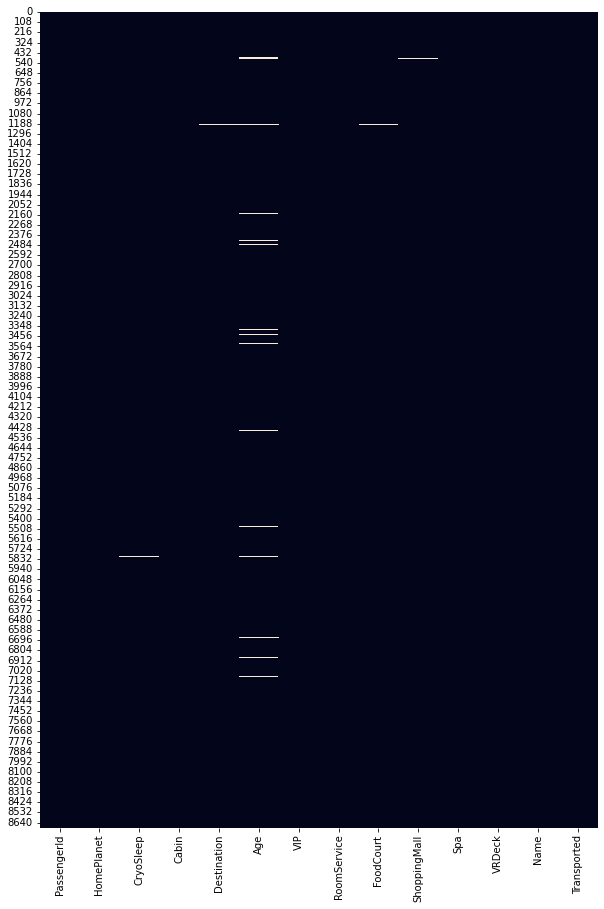

In [15]:
import seaborn as sns
from matplotlib.pyplot import figure
figure(figsize = (10, 15))
sns.heatmap(train.isnull(), cbar=False)

In [16]:
train = train.fillna(train.mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [17]:
train = train.fillna(0)

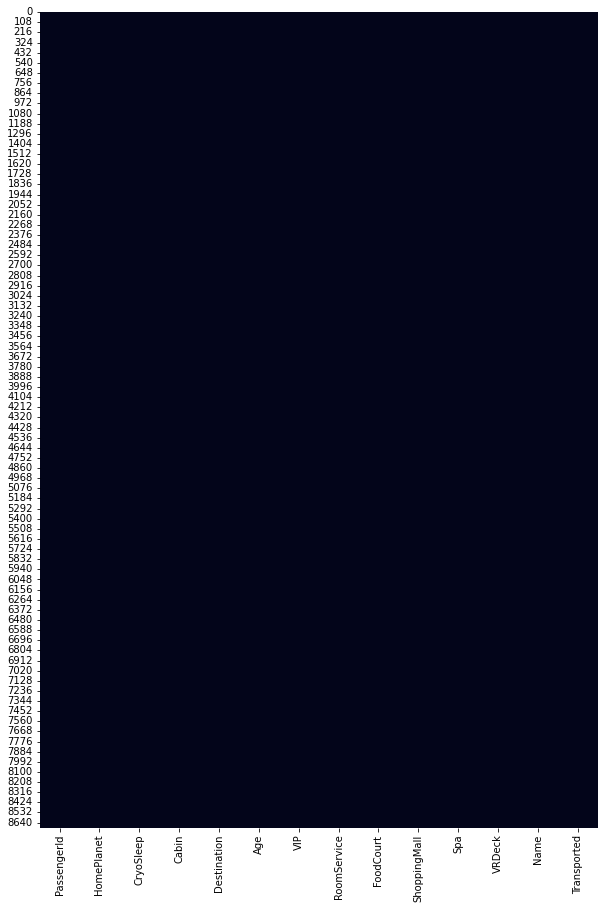

In [18]:
import seaborn as sns
from matplotlib.pyplot import figure
figure(figsize = (10, 15))
sns.heatmap(train.isnull(), cbar=False)

In [19]:
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [20]:
# Тестовая выборка
#  Возраст
colum_num = 5
# создадим вспомогательную функцию для определния значения объема по 3 параметрам 
def Value_string_det_test (a1,a2,a3,n_columns):
    try: # пробуем получить значение по трем ключевым значениям 'Класс здания', 'Район', 'Год'
        answ_test = test.iloc[(test[((test.iloc[:,1] == a1) & (test.iloc[:,2] == a2) & (test.iloc[:,3] == a3))]).index,\
                            n_columns ].value_counts().index[0]
    except:
        try: # в случае если операция не дала результа определяем значение поля на основе 'Класс здания' и максимально частоты использования. 
            answ_test = test.iloc[(test[test.iloc[:,1] == a1]).index,n_columns].value_counts().index[0]
        except: # в случае если с помощью предыдущих операций, мы не получили результат, то возвращаем значение, чаще встречающееся по все базе
            answ_test = test.iloc[:,n_columns].value_counts().index[0]
    
    return answ_test

In [21]:
maskValue = test.iloc[:,colum_num].isna() # создаем маску с пустыми значениями для колонки "Забор"
df_val = test.loc[maskValue,:] # создаем вспомогательным датафрейм
print(df_val.shape) # выведем размерность этого дата фрейма
df_val.head(10) # выведем на экран строки с пустыми значениями для колонки "Забор"

(91, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
42,0100_01,Earth,False,G/13/P,TRAPPIST-1e,NaN,NaN,0.0,17.0,997.0,0.0,0.0,Dary Cochrisons
68,0156_01,Mars,NaN,F/34/P,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Tures Upead
146,0319_02,Mars,True,F/69/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Pigars Prie
157,0339_05,Earth,True,G/56/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Davisy Colleruces
211,0467_02,Mars,True,D/17/P,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,NaN,Cings Keen
328,0717_03,Europa,True,B/31/P,NaN,NaN,False,0.0,0.0,0.0,0.0,0.0,Nesch Panspic
334,0720_02,Mars,False,E/52/S,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Krus Buko
339,0725_01,Earth,True,G/110/P,PSO J318.5-22,NaN,False,0.0,0.0,0.0,0.0,0.0,Joycey Hewson
488,1050_01,NaN,True,G/157/P,TRAPPIST-1e,NaN,False,0.0,0.0,NaN,0.0,0.0,Evendy Buchansen
547,1137_01,Europa,False,E/82/S,TRAPPIST-1e,NaN,False,0.0,1537.0,NaN,112.0,753.0,Vindem Unings


In [22]:
list_val = df_val.iloc[:,[1, 2, 3]].values.tolist() # переводим для того, что бы пробежаться по значениям.
list_value =[Value_string_det_test(a1,a2,a3,colum_num) for a1,a2,a3 in list_val] # создадим вспомогательный список со значениям поля "Забор".
df_val.loc[:,'New'] = list_value # присвоим новой колонке значения списка с рассчитанными значениями.

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [23]:
test.iloc[:,colum_num].fillna(value=df_val.iloc[:,5],inplace=True) # заполняем все значения поля "Забор", имеющие пустые значения.

In [24]:
colum_num_list = [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12] # список номеров столбцов которые необходимо заполнить.
for colum_num in colum_num_list: # пройдемся в цикле по всем столбцам.
    maskValue = test.iloc[:,colum_num].isna() # создаем маску с пустыми значениями для колонки.
    df_val = test.loc[maskValue,:] # создаем вспомогательным датафрейм.
    list_val = df_val.iloc[:,[1, 2, 3]].values.tolist() # переводим для того, что бы пробежаться по значениям.
    list_value =[Value_string_det_test(a1,a2,a3,colum_num) for a1,a2,a3 in list_val] # создадим вспомогательный список со значениям поля.
    df_val.loc[:,'New'] = list_value # присвоим новой колонке значения списка с рассчитанными значениями. 
    test.iloc[:,colum_num].fillna(value=df_val.iloc[:,5],inplace=True) # заполняем все значения поля, имеющие пустые значения.

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [25]:
test = test.fillna(test.mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [26]:
test = test.fillna(0)

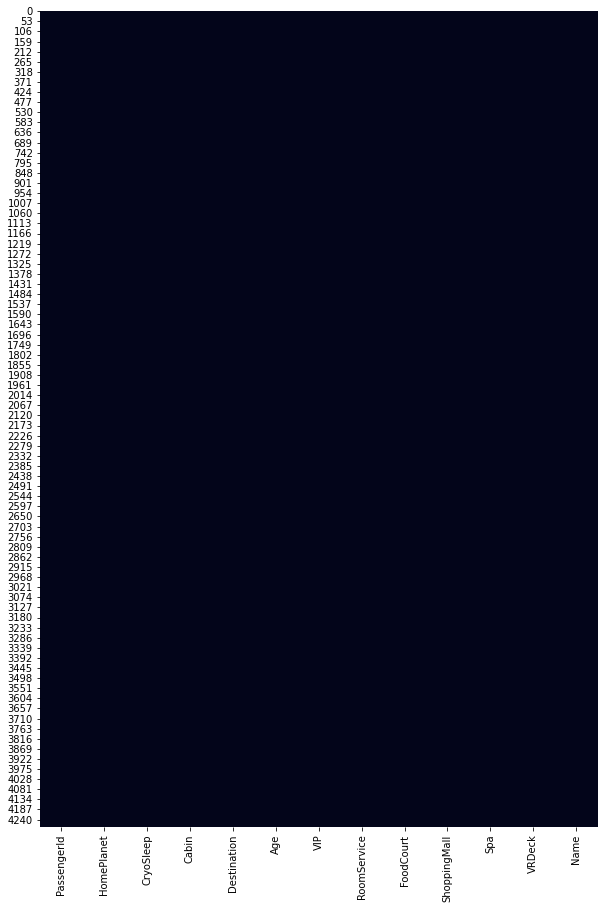

In [27]:
import seaborn as sns
from matplotlib.pyplot import figure
figure(figsize = (10, 15))
sns.heatmap(test.isnull(), cbar=False)

In [28]:
test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.000000,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.000000,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.000000,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.000000,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.000000,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.000000,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,42.0,TRAPPIST-1e,42.000000,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,28.658146,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,0,28.658146,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [29]:
# Разбиваем столбец Кабин на три столбца
train[['deck', 'num','side']] = train['Cabin'].str.split('/', expand=True)
train=train.drop(['Cabin'],axis=1)
train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


In [30]:
# Разбиваем столбец Кабин на три столбца
test[['deck', 'num','side']] = test['Cabin'].str.split('/', expand=True)
test=test.drop(['Cabin'],axis=1)
test

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,deck,num,side
0,0013_01,Earth,True,TRAPPIST-1e,27.000000,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,G,3,S
1,0018_01,Earth,False,TRAPPIST-1e,19.000000,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,F,4,S
2,0019_01,Europa,True,55 Cancri e,31.000000,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,C,0,S
3,0021_01,Europa,False,TRAPPIST-1e,38.000000,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,C,1,S
4,0023_01,Earth,False,TRAPPIST-1e,20.000000,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,F,5,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,TRAPPIST-1e,34.000000,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,G,1496,S
4273,9269_01,Earth,False,TRAPPIST-1e,42.000000,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,NaN,NaN
4274,9271_01,Mars,True,55 Cancri e,28.658146,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,D,296,P
4275,9273_01,Europa,False,0,28.658146,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,D,297,P


In [31]:
train

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,A,98,P
8689,9278_01,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,G,1499,S
8690,9279_01,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,G,1500,S
8691,9280_01,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,E,608,S


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   object 
 3   Destination   8693 non-null   object 
 4   Age           8693 non-null   float64
 5   VIP           8693 non-null   object 
 6   RoomService   8693 non-null   float64
 7   FoodCourt     8693 non-null   float64
 8   ShoppingMall  8693 non-null   float64
 9   Spa           8693 non-null   float64
 10  VRDeck        8693 non-null   float64
 11  Name          8693 non-null   object 
 12  Transported   8693 non-null   bool   
 13  deck          8494 non-null   object 
 14  num           8494 non-null   object 
 15  side          8494 non-null   object 
dtypes: bool(1), float64(6), object(9)
memory usage: 1.0+ MB


In [33]:
# перечень столбцов которые необходимо переводить в числовые значения
colum_num_list = [0, 1, 2, 3, 5, 11, 13, 14, 15]
 # список уникальных значений для каждого текстового столбца
name_list = [0, 0, 0, 0, 0, 0, 0, 0, 0]
for i, n_l in enumerate(colum_num_list):
    name_list[i] = train.iloc[:,n_l].unique().tolist()
    print(len(name_list[i]))

8693
59
62
54
62
8537
9
1818
3


In [34]:
# заполняем данные и переводим текчтовые данные в числовые 
def get_Data(item_list):
    xTrain = []
    yTrain = []
    for item in item_list:
        stroka = []
        for i, n_l in enumerate(colum_num_list):
            # переводим текстовые значения в числовые путем присвоения индекса уникальности. 
            stroka.append(name_list[i].index(item[n_l])) 
        for i in (4, 6, 7, 8, 9, 10):
            # вставляем значения которые осталичь без изменения.
            stroka.insert(i,item[i]) 
        yTrain.append(item[12])  # добавляем массив  ответов на основе 11 столбца "Цена" 
        xTrain.append(stroka) # добавляем массив параметров на основе сформированных данных
    xTrain = np.array(xTrain, dtype=np.float) # переводим к единому типу и в формат numpy
    yTrain = np.array(yTrain, dtype=np.float)
    return (xTrain, yTrain)

In [35]:
(xTrain, yTrain) = get_Data(train.values) # Извлекаем значения загруженного набора данных

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


In [36]:
# Размер набора параметров и стоимость автомобиля
print(xTrain.shape) 
print(yTrain.shape)
# Пример обработанных данных
n = 12
print(xTrain[n])
print(yTrain[n])

(8693, 15)
(8693,)
[1.200e+01 2.000e+00 0.000e+00 0.000e+00 3.200e+01 0.000e+00 7.300e+01
 0.000e+00 1.123e+03 0.000e+00 1.130e+02 1.200e+01 1.000e+00 1.000e+00
 0.000e+00]
1.0


In [37]:
test.info() # Проверяем значение каждой колонки должны иметь заданный тип данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4277 non-null   object 
 2   CryoSleep     4277 non-null   object 
 3   Destination   4277 non-null   object 
 4   Age           4277 non-null   float64
 5   VIP           4277 non-null   object 
 6   RoomService   4277 non-null   float64
 7   FoodCourt     4277 non-null   float64
 8   ShoppingMall  4277 non-null   float64
 9   Spa           4277 non-null   float64
 10  VRDeck        4277 non-null   float64
 11  Name          4277 non-null   object 
 12  deck          4177 non-null   object 
 13  num           4177 non-null   object 
 14  side          4177 non-null   object 
dtypes: float64(6), object(9)
memory usage: 501.3+ KB


In [38]:
# перечень столбцов которые необходимо переводить в числовые значения
colum_num_list = [0,1,2,3,5,11,12,13,14]
 # список уникальных значений для каждого текстового столбца
name_list = [0,0,0,0,0,0,0,0,0]
for i, n_l in enumerate(colum_num_list):
    name_list[i] = test.iloc[:,n_l].unique().tolist()
    print(len(name_list[i]))

4277
49
46
43
47
4218
9
1506
3


In [39]:
# заполняем данные и переводим текчтовые данные в числовые 
def get_Data_test(item_list):
    xTest = []
    
    for item in item_list:
        stroka = []
        for i, n_l in enumerate(colum_num_list):
            # переводим текстовые значения в числовые путем присвоения индекса уникальности. 
            stroka.append(name_list[i].index(item[n_l])) 
        for i in (4,6,7,8,9,10):
            # вставляем значения которые осталичь без изменения.
            stroka.insert(i,item[i]) 
        
        xTest.append(stroka) # добавляем массив параметров на основе сформированных данных
    xTest = np.array(xTest, dtype=np.float) # переводим к единому типу и в формат numpy
    
    return (xTest)

In [40]:
(xTest) = get_Data_test(test.values) # Извлекаем значения загруженного набора данных

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


In [41]:
# Размер набора параметров и стоимость автомобиля
print(xTest.shape) 

(4277, 15)


In [42]:
# нормализуем данные, на вход должно подаваться в каждой цифре не больше 1 по величине (от 0 до 1 - обычно), иначе сеть плохо учится
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # для нормализации данных
xScaler = MinMaxScaler() # используем функцию нормализации
xTrainScaled = xScaler.fit_transform(xTrain) # сначала обучаем на тренировочных данных, потом трансформируем их

yScaler = MinMaxScaler() # Скармливаем объекту двумерный вектор
yTrainScaled = yScaler.fit_transform(yTrain.reshape(-1,1)).flatten() # Нормализуем по нормальному распределению

In [43]:
xScaler = MinMaxScaler() # используем функцию нормализации
xTestScaled = xScaler.fit_transform(xTest) # сначала обучаем на тренировочных данных, потом трансформируем их

In [44]:
# sklearn - библиотека для машинного обучения
# train_test_split - метод разделения на обучающую и тестовую выборку
# test_size=0.15 - будет выделено 15% от тренировочных данных 
# shuffle=True - перемешать данные
# x_train - данные для обучения, y_train - правильные ответы для обучения
# x_test - данные для проверки, y_test - правильные ответы для проверки

x_train, x_test, y_train, y_test = train_test_split(xTrainScaled, yTrainScaled, test_size=0.001, shuffle=True)    
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)


(8684, 15)
(9, 15)
(8684,)
(9,)


In [59]:
# Создадим модель
def createModelHouse(input_my):
    model = Sequential()
    model.add(BatchNormalization(input_shape=(input_my,)))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1000, activation='tanh'))
    model.add(Dense(900, activation='tanh'))
    #model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(800, activation='tanh'))
    model.add(Dense(700, activation='tanh'))
    model.add(Dense(600, activation='tanh'))
    model.add(Dense(500, activation='tanh'))
    model.add(Dense(400, activation='tanh'))
    #model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(300, activation='tanh'))
    model.add(Dense(200, activation='tanh'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    #model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [60]:
# Обучаем модель полученными данными
modelHouse = createModelHouse(x_train.shape[1])
history = modelHouse.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=50,
                    validation_split=0.15, 
                    verbose=1)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


148/148 [==============================] - 9s 51ms/step - loss: 0.5437 - accuracy: 0.7193 - val_loss: 0.7244 - val_accuracy: 0.5618
Epoch 2/100
148/148 [==============================] - 7s 48ms/step - loss: 0.5073 - accuracy: 0.7448 - val_loss: 0.6679 - val_accuracy: 0.6378
Epoch 3/100
148/148 [==============================] - 7s 48ms/step - loss: 0.4936 - accuracy: 0.7503 - val_loss: 0.5550 - val_accuracy: 0.6884
Epoch 4/100
148/148 [==============================] - 7s 48ms/step - loss: 0.4819 - accuracy: 0.7601 - val_loss: 0.4825 - val_accuracy: 0.7429
Epoch 5/100
148/148 [==============================] - 7s 48ms/step - loss: 0.4738 - accuracy: 0.7701 - val_loss: 0.4594 - val_accuracy: 0.7675
Epoch 6/100
148/148 [==============================] - 7s 48ms/step - loss: 0.4658 - accuracy: 0.7681 - val_loss: 0.4502 - val_accuracy: 0.7805
Epoch 7/100
148/148 [==============================] - 7s 48ms/step - loss: 0.4652 - accuracy: 0.7652 - val_loss: 0.4488 - val_accuracy: 0.7836
Epoc

In [61]:
# Обучаем модель полученными данными
#modelHouse = createModelHouse(x_train.shape[1])
history = modelHouse.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=20,
                    validation_split=0.15, 
                    verbose=1)

Epoch 1/100
370/370 [==============================] - 14s 38ms/step - loss: 0.3969 - accuracy: 0.8109 - val_loss: 0.4535 - val_accuracy: 0.7913
Epoch 2/100
370/370 [==============================] - 13s 35ms/step - loss: 0.3975 - accuracy: 0.8068 - val_loss: 0.4574 - val_accuracy: 0.7690
Epoch 3/100
370/370 [==============================] - 13s 35ms/step - loss: 0.3918 - accuracy: 0.8071 - val_loss: 0.4348 - val_accuracy: 0.8012
Epoch 4/100
370/370 [==============================] - 13s 35ms/step - loss: 0.3923 - accuracy: 0.8110 - val_loss: 0.4388 - val_accuracy: 0.7913
Epoch 5/100
370/370 [==============================] - 13s 35ms/step - loss: 0.3829 - accuracy: 0.8128 - val_loss: 0.4499 - val_accuracy: 0.7936
Epoch 6/100
370/370 [==============================] - 13s 35ms/step - loss: 0.3800 - accuracy: 0.8144 - val_loss: 0.4318 - val_accuracy: 0.7913
Epoch 7/100
370/370 [==============================] - 13s 36ms/step - loss: 0.3854 - accuracy: 0.8110 - val_loss: 0.4480 - val_ac

In [62]:
modelHouse.save('/content/drive/MyDrive/datasets/titanik_ship/my_modelHouse.h5') # сохраним обученную модель

In [63]:
prediction_house = modelHouse.predict(x_test) # сделаем предсказание нашей моделью тестовой выборки
predUnscaled = yScaler.inverse_transform(prediction_house).flatten() # приведем предсказания к начальному виду до нормирования
y_testUnscaled = yScaler.inverse_transform(y_test.reshape(1,-1)).flatten()# приведем y_test к начальному виду до нормирования
# Среднее значение ошибки 
delta = abs(predUnscaled - y_testUnscaled)
print('Среднее значение ошибки ',sum(delta) / len(delta))

Среднее значение ошибки  0.3036549952295091


In [64]:
prediction_house = modelHouse.predict(xTest) # сделаем предсказание нашей моделью тестовой выборки
predUnscaled = yScaler.inverse_transform(prediction_house).flatten() # приведем предсказания к начальному виду до нормирования
#y_testUnscaled = yScaler.inverse_transform(y_test.reshape(1,-1)).flatten()# приведем y_test к начальному виду до нормирования
# Среднее значение ошибки 
#delta = abs(predUnscaled - y_testUnscaled)
#print('Среднее значение ошибки ',sum(delta) / len(delta))

In [65]:
predUnscaled

array([2.5663990e-01, 2.4551153e-04, 3.6402866e-01, ..., 9.6635592e-01,
       9.8353630e-01, 9.7080553e-01], dtype=float32)

In [66]:
predUnscaled = predUnscaled.astype('bool')

In [67]:
predUnscaled

array([ True,  True,  True, ...,  True,  True,  True])

In [68]:
submission=pd.DataFrame({'PassengerId': test.PassengerId,
                       'Transported': predUnscaled})
submission.to_csv('submission.csv', index=False)

submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,True
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [69]:
sample_submission = submission.to_csv('/content/drive/MyDrive/my_databases/sample_submission.csv', sep=',', index=False, header=True)